In [1]:
import torch

if torch.backends.mps.is_available():
    print("MPS backend is available.")
else:
    print("MPS backend is not available.")

MPS backend is available.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)  
    return pd.DataFrame(data)

df = load_data('../fast_russian_embeddings.json')

In [4]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])
X = np.array(df['embedding'].tolist(), dtype=np.float32) 
y = df['label_encoded'].values

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
EMBEDDING_DIM = 312
NUM_CLASSES = 3
BATCH_SIZE =64

train_dataset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.int32)
    )
val_dataset = TensorDataset(
        torch.tensor(X_val, dtype=torch.float32),
        torch.tensor(y_val, dtype=torch.int32)
    )
test_dataset = TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.int32)
    )

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [7]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train 
)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
class_weights = torch.tensor(np.log(class_weights + 1) * 0.5, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [8]:
class BiLSTM_CNN(nn.Module):
    def __init__(self, 
                 embedding_dim=312,
                 hidden_dim=512,  
                 num_classes=3,
                 n_filters=100,
                 filter_sizes=[1, 3, 5],
                 dropout=0.3):
        super().__init__()
        
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim,
            bidirectional=True,
            batch_first=True,
            dropout=0.3 
        )
        
        self.convs = nn.ModuleList([
            nn.Conv1d(
                2 * hidden_dim, 
                n_filters, 
                kernel_size=fs,
                padding=(fs - 1) // 2  # Паддинг для сохранения размера
            ) 
            for fs in filter_sizes
        ])
        
        self.bn = nn.BatchNorm1d(len(filter_sizes) * n_filters)
        self.fc = nn.Linear(len(filter_sizes) * n_filters, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
            
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out.permute(0, 2, 1)  # (batch, channels, seq_len)
        
        pooled = []
        for conv in self.convs:
            conv_out = F.relu(conv(lstm_out))
            pooled_out = F.max_pool1d(conv_out, conv_out.size(2))
            pooled.append(pooled_out)
            
        cat = self.bn(torch.cat(pooled, dim=1).squeeze(2))
        return self.fc(self.dropout(cat))

In [9]:
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for batch in iterator:
        x, y = batch
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        predictions = model(x)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(predictions, 1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        epoch_loss += loss.item()
        
    acc = correct / total
    return epoch_loss / len(iterator), acc

In [10]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in iterator:
            x, y = batch
            x, y = x.to(device), y.to(device)
            
            predictions = model(x)
            loss = criterion(predictions, y)
            epoch_loss += loss.item()
            
            _, preds = torch.max(predictions, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    acc = (np.array(all_preds) == np.array(all_labels)).mean()
    return epoch_loss / len(iterator), acc

In [23]:
model = BiLSTM_CNN(
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=512,
    num_classes=NUM_CLASSES,
    n_filters=200,
    filter_sizes=[3,5,7],
    dropout=0.3
)
model = model.to(device)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [32]:
# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

optimizer = optim.SGD(
    model.parameters(), 
    lr=0.0001, 
    momentum=0.9, 
    nesterov=True, 
    weight_decay=1e-4
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.1, 
    patience=1
)
# scheduler = optim.lr_scheduler.CyclicLR(
#     optimizer, 
#     base_lr=0.00001, 
#     max_lr=0.1, 
#     step_size_up=2000
# )

In [17]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [ ]:
early_stopping = EarlyStopping(patience=5)
N_EPOCHS = 20

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)
    
    # Update scheduler
    scheduler.step(valid_loss)
    
    # Early stopping check
    early_stopping(valid_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break
    
    # Save best model
    if valid_loss == early_stopping.best_loss:
        torch.save(model.state_dict(), 'best_model.pth')
    
    # Print metrics
    print(f"Epoch {epoch+1:02}")
    print(f"\tTrain Loss: {train_loss:.4f} Acc: {train_acc*100:.2f}%")
    print(f"\tVal Loss: {valid_loss:.4f} Acc: {valid_acc*100:.2f}%")

Epoch 01
	Train Loss: 0.7409 Acc: 71.84%
	Val Loss: 0.7526 Acc: 71.83%


Test Loss: 0.7444
Accuracy: 71.00%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.54      0.72      0.62      2921
     Neutral       0.40      0.44      0.42      3780
    Positive       0.88      0.79      0.83     13050

    accuracy                           0.71     19751
   macro avg       0.61      0.65      0.62     19751
weighted avg       0.73      0.71      0.72     19751



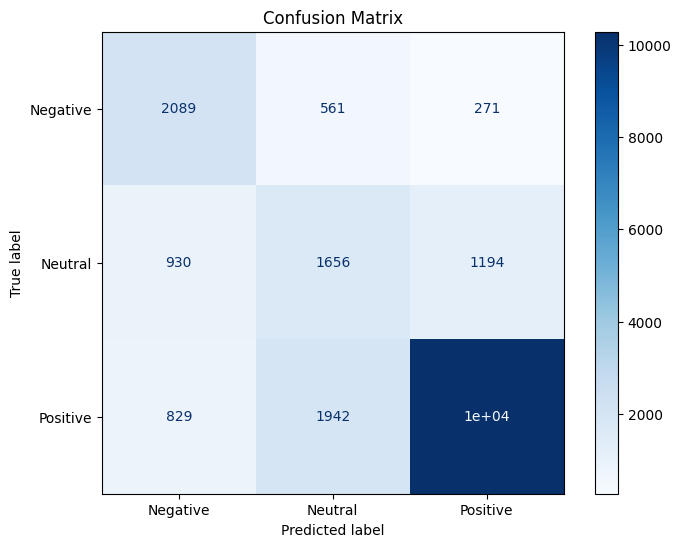

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, test_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x = x.to(device).float()
            y = y.to(device).long()
            
            
            if x.dim() == 2:
                x = x.unsqueeze(1)
                
            outputs = model(x)
            loss = criterion(outputs, y)
            test_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    # Вычисляем метрики
    test_loss /= len(test_loader)
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8,6))
    disp.plot(ax=ax, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    
    return test_loss, accuracy


class_names = ['Negative', 'Neutral', 'Positive']  
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)

test_loss, test_acc = evaluate_model(model, test_loader, device, class_names)